In [1]:
import sympy as sp
sp.init_printing()

import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

# Pfadtrajektorie

In [2]:
a, v, t, s = sp.symbols('a v t s', nonnegative=True)
T = sp.symbols('T', positive=True)

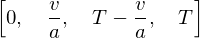

In [3]:
time = [0, v/a, T-v/a, T]
time

## Beschleunigungsphase

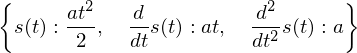

In [4]:
v0 = 0;
s0 = 0;

p1 = {s(t).diff(t,t): a,
      s(t).diff(t)  : a.integrate(t) + v0,
      s(t)          : a.integrate(t,t) + v0*t + s0}
p1

## Gleichmäßige Geschwindigkeit

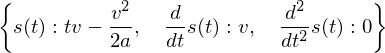

In [5]:
v0 = p1[s(t).diff(t)].subs(t,time[1]);
s0 = p1[s(t)].subs(t,time[1]);

p2 = {s(t).diff(t,t): 0,
      s(t).diff(t)  : v0,
      s(t)          : sp.simplify(v0*(t-time[1]) + s0)}
p2

## Verzögerungsphase

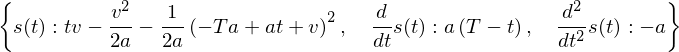

In [6]:
v0 = p2[s(t).diff(t)].subs(t,time[2]);
s0 = p2[s(t)].subs(t,time[2]);

p3 = {s(t).diff(t,t): -a,
      s(t).diff(t)  : sp.simplify(-a.integrate(t).subs(t,t-time[2]) + v0),
      s(t)          : sp.simplify(-a.integrate(t,t).subs(t,t-time[2]) + v0*(t-time[2]) + s0)}
p3

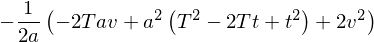

In [7]:
sp.simplify(p3[s(t)]).factor().collect(a**2)

## Pfadbeschreibung

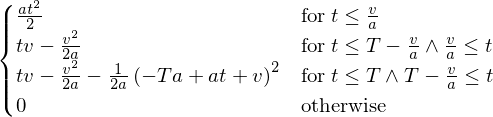

In [8]:
path = sp.Piecewise( (s(t).subs(p1), sp.And(0 <= t, t <= time[1])),
                     (s(t).subs(p2), sp.And(time[1] <= t, t <= time[2])),
                     (s(t).subs(p3), sp.And(time[2] <= t, t <= time[3])),
                     (0            , True)
                   )
path

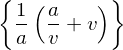

In [9]:
T_res = sp.solveset(sp.Eq(p3[s(t)].subs(t,T), 1), T)
T_res

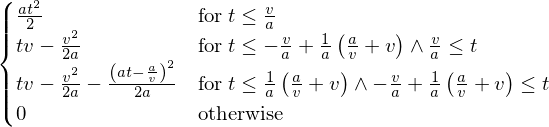

In [10]:
path = path.subs(T, *T_res)
path

In [11]:
s_func = sp.lambdify((v,a,t),path)
sd_func = sp.lambdify((v,a,t),path.diff(t))
sdd_func = sp.lambdify((v,a,t),path.diff(t,t))

t_func = sp.lambdify((v,a),*T_res)

def plotPathTrajectory(v,a):
    t = np.arange(0, t_func(v,a), 0.001) 
    data = [s_func(v,a,t), sd_func(v,a,t), sdd_func(v,a,t)]
    labels = ['s [1]', 'sd [1]', 'sdd [1]']
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,10))
    
    for values, axis, label in zip(data, axes, labels):
        axis.plot(t, values)
        axis.set_ylabel(label)
        axis.grid()
        
    plt.xlabel('Time [sec]')
    
    

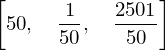

In [12]:
[exp.subs(T,*T_res).subs({v:50,a:1}) for exp in time[1:4]]

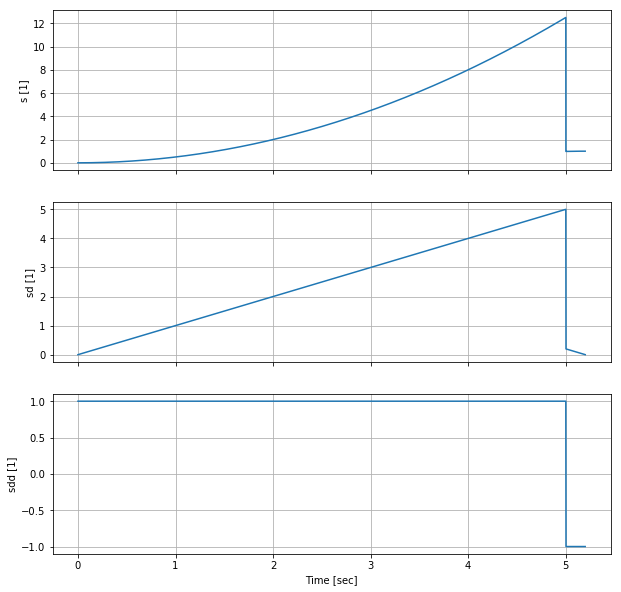

In [13]:
plotPathTrajectory(5,1)

## Nebenbedingungen

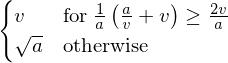

In [14]:
exp_ineq = (T >= 2*(v/a)).subs(T, *T_res)
exp_equal = sp.Eq(T, 2*(v/a)).subs(T, *T_res)

v_res = sp.Piecewise( (v, exp_ineq), 
                      (sp.solve(exp_equal,v, domain=sp.S.Reals)[1], True) )

v_res

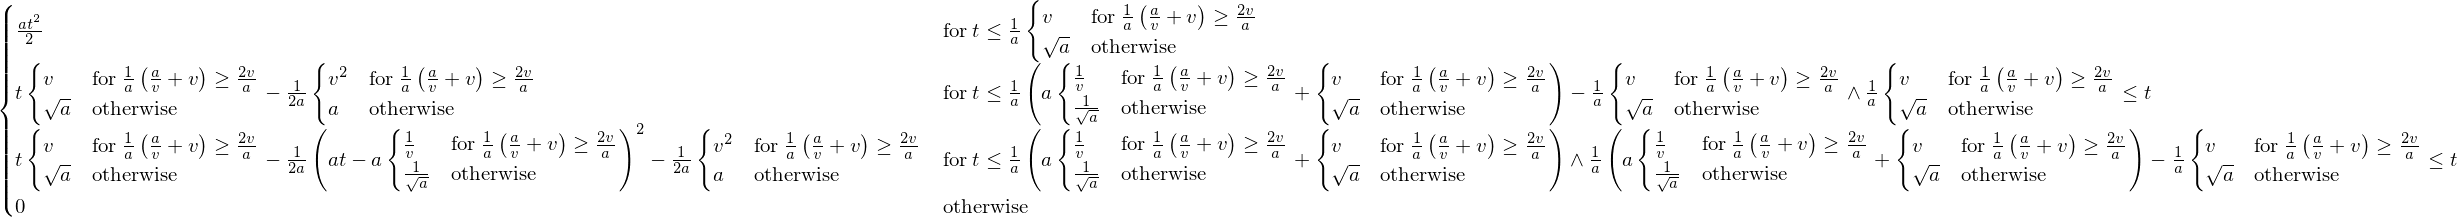

In [15]:
path = path.subs(v, v_res)
path

In [16]:
s_func = sp.lambdify((v,a,t),path)
sd_func = sp.lambdify((v,a,t),path.diff(t))
sdd_func = sp.lambdify((v,a,t),path.diff(t,t))

t_func = sp.lambdify((v,a),*T_res.subs(v, v_res))

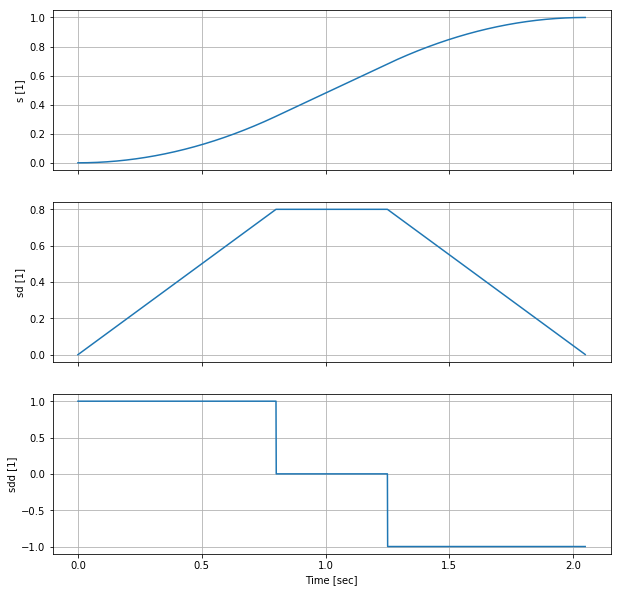

In [17]:
plotPathTrajectory(0.8,1)

# Gelenktrajektorie

In [18]:
def plotJointTrajectory(th_s, th_e, v, a):    
    
    t = np.arange(0, t_func(v,a), 0.001) 
    
    s = s_func(v,a,t)
    sd = sd_func(v,a,t)
    sdd = sdd_func(v,a,t)
    
    labels = ['s [deg]', 'sd [deg]', 'sdd [deg]','th [deg]', 'thd [deg]', 'thdd [deg]']
    
    th   = th_s + np.dot(s[None].T, (th_e-th_s))
    thd  = np.dot(sd[None].T, (th_e-th_s))
    thdd = np.dot(sdd[None].T, (th_e-th_s))
    
    fig, axes = plt.subplots(3, 2, sharex=True, figsize=(10,10))
    axes = axes.T.reshape(1,6)
    
    for values, axis, label in zip([s, sd, sdd, th, thd, thdd,], axes[0], labels):
        axis.plot(t, values)
        axis.set_ylabel(label)
        axis.grid()
        
    plt.xlabel('Time [sec]')
    

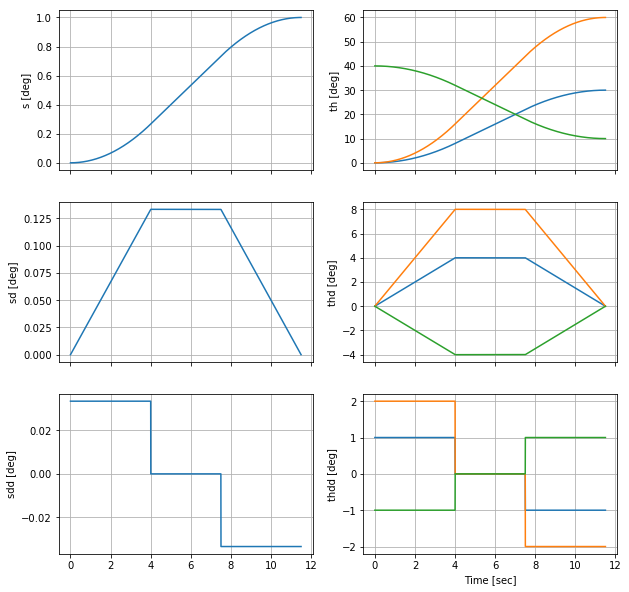

In [19]:
th_s     = np.array([[0, 0, 40]])
th_e     = np.array([[30, 60, 10]])
thd_lim  = np.array([[5, 8, 7]])
thdd_lim = np.array([[2, 2, 3]]) 

v_max = np.min(thd_lim/abs(th_e-th_s))
a_max = np.min(thdd_lim/abs(th_e-th_s))

plotJointTrajectory(th_s, th_e, v_max, a_max)